In [ ]:
import cv2 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import pandas as pd
from tensorflow import keras
import seaborn as sns
from keras.models import Sequential,load_model
from keras.layers import LeakyReLU,Conv2D,Activation, MaxPooling2D,Dense,Flatten,ReLU
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from collections import deque

In [ ]:
BASE_DIR = Path().resolve().parent
# waste = BASE_DIR / "detection_waste/out"
waste = BASE_DIR / "plasticcsv"
train_data = waste / "train"
test_data = waste / "test"
print('train_data :', train_data)
classes = ('other', 'plastic')


train_data : /content/drive/MyDrive/plsticcsv/train


In [ ]:

#Build CNN Model
#1
model = keras.Sequential()
model.add(keras.Input(shape=(250, 250, 3)))  # 250x250x3 RGB images
model.add(keras.layers.Conv2D(32, 5, strides=2, use_bias=False))  # output: 123x123x32
model.add(keras.layers.BatchNormalization(axis=3))  # Axis=3 "channels" is the 3rd axis of default data_format(batch_size, height, width, channels)
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv2D(64, 3, use_bias=False))  # output: 121x121x64
model.add(keras.layers.BatchNormalization(axis=3))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.MaxPooling2D(3))  # output: 40x40x64

model.add(keras.layers.Conv2D(128, 3, use_bias=False))  # output: 38x38x128
model.add(keras.layers.BatchNormalization(axis=3))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.MaxPooling2D(3))  # output: 12x12x128

# Classification layer.
model.add(keras.layers.Flatten())  # 1x1x18432
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))  # 1x1x128
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 1x1x1

opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)  # w = w + momentum * velocity - lr * grad

# compile model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

#  Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 32)      2400      
                                                                 
 batch_normalization (BatchN  (None, 123, 123, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 123, 123, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 121, 64)      18432     
                                                                 
 batch_normalization_1 (Batc  (None, 121, 121, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 121, 121, 64)      0

In [ ]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0,

                             validation_split=0.3)

# prepare iterators

train_it = datagen.flow_from_directory('train', class_mode='binary', batch_size=32, target_size=(250, 250),subset='training')
valid_it= datagen.flow_from_directory('train', class_mode='binary', batch_size=32, target_size=(250, 250),subset='validation',shuffle=False)

# fit model
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=valid_it, validation_steps=len(valid_it),
                    epochs=30, verbose=1, callbacks=[es], workers=10)


Found 1532 images belonging to 2 classes.
Found 656 images belonging to 2 classes.
Epoch 1/30
48/48 [==============================] - 220s 4s/step - loss: 0.6235 - accuracy: 0.7174 - val_loss: 0.6821 - val_accuracy: 0.7012
Epoch 2/30
48/48 [==============================] - 184s 4s/step - loss: 0.4336 - accuracy: 0.8029 - val_loss: 0.6645 - val_accuracy: 0.6021
Epoch 3/30
48/48 [==============================] - 181s 4s/step - loss: 0.3796 - accuracy: 0.8277 - val_loss: 0.6459 - val_accuracy: 0.6021
Epoch 4/30
48/48 [==============================] - 180s 4s/step - loss: 0.3109 - accuracy: 0.8675 - val_loss: 0.6121 - val_accuracy: 0.6845
Epoch 5/30
48/48 [==============================] - 191s 4s/step - loss: 0.2703 - accuracy: 0.8943 - val_loss: 0.5779 - val_accuracy: 0.7591
Epoch 6/30
48/48 [==============================] - 183s 4s/step - loss: 0.2852 - accuracy: 0.8668 - val_loss: 0.5376 - val_accuracy: 0.8613
Epoch 7/30
48/48 [==============================] - 185s 4s/step - loss

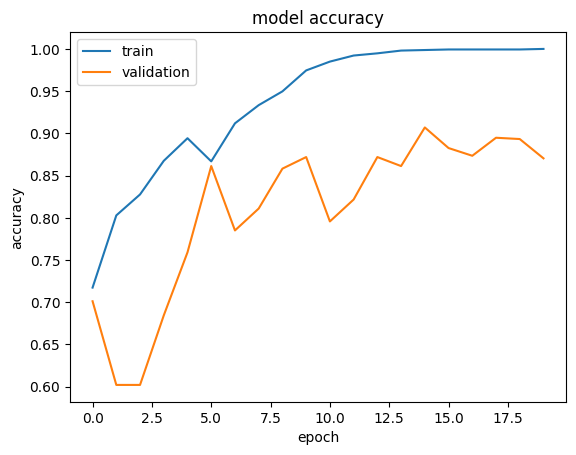

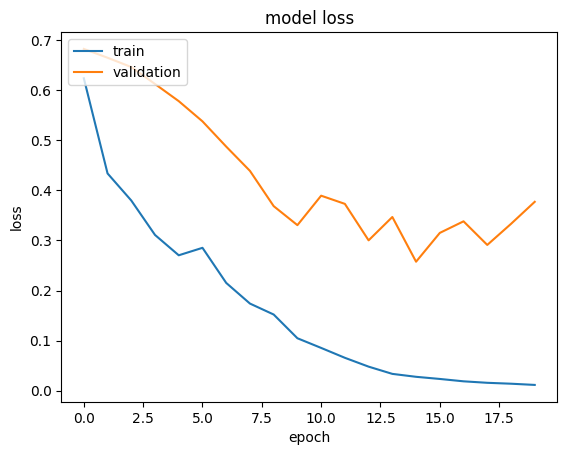

In [ ]:

##################### Test the model ######################
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# save model
model.save('detection_waste_plastic.h5')

Found 436 images belonging to 2 classes.
14/14 [==============================] - 12s 764ms/step

Confusion Matrix
 -------------------------
[[120  54]
 [  4 258]]
Accuracy: 0.866972
Precision: 0.826923
Recall: 0.984733
F1 score: 0.898955
ROC AUC: 0.958322


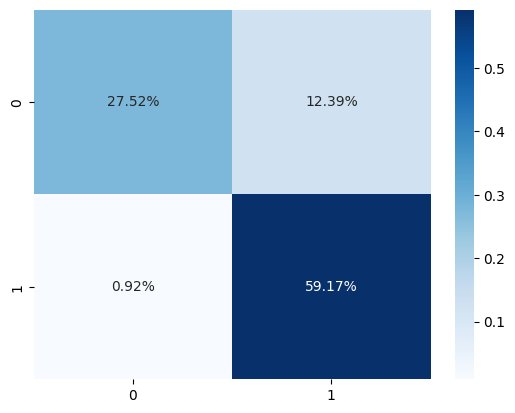

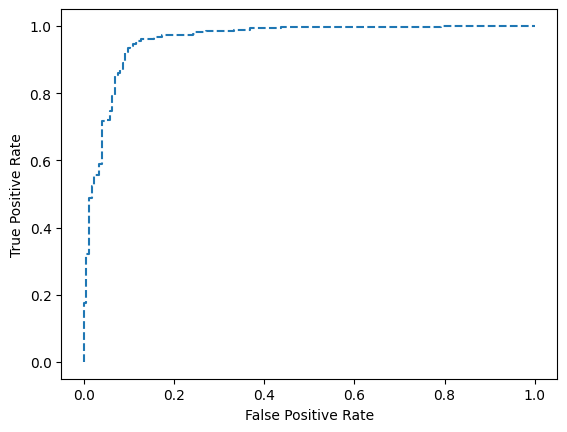

In [ ]:
#Evaluate CNN Model

    
# load model
model = load_model('detection_waste_plastic.h5')

 
# load test data
tst_datagen = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.2)

test_it= tst_datagen.flow_from_directory('/content/drive/MyDrive/plsticcsv/train', class_mode='binary',shuffle=False
                                         , batch_size=32, target_size=(250, 250),subset='validation')


y_true = test_it.classes

y_pred = model.predict(test_it, steps=len(test_it), verbose=1)

y_pred_binary = y_pred> 0.5


#confusion Matrix    
print('\nConfusion Matrix\n -------------------------')    
print(confusion_matrix(y_true,y_pred_binary))

sns.heatmap(confusion_matrix(y_true,y_pred_binary)/np.sum(confusion_matrix(y_true,y_pred_binary)), annot=True,
        fmt='.2%', cmap='Blues')

# accuracy: (tp + tn) / (p + n)

accuracy = accuracy_score(y_true, y_pred_binary)
print('Accuracy: %f' % accuracy)


# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_binary)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_binary)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true,y_pred_binary)
print('F1 score: %f' % f1)    
    
# ROC AUC
auc = roc_auc_score(y_true, y_pred)
print('ROC AUC: %f' % auc)


# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred)
# plot the roc curve for the model
plt.figure()
plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')

# axis labels
plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')       
# show the plot
plt_False_Positive_vs_True_Positive.show()

In [ ]:
import math

import cv2
import numpy as np
import pandas as pd
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from shapely import Polygon

def getROIs(image):
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    dilate = cv2.dilate(thresh, kernel, iterations=1)

    # Find contours, obtain bounding box coordinates, and extract ROI

    cnts, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)


    ret = pd.DataFrame(columns = ['x', 'y', 'w', 'h'])
    ROIs = []
    gray_images = []
    contours = []
    for i in range(0, len(cnts)):
        gray_image = np.zeros((1000, 1000), dtype='uint8')
        h = len(cnts[i])
        d = len(cnts[i][0])
        w = len(cnts[i][0][0])
        cnt = np.resize(cnts[i], (h, w))
        poly = Polygon(cnt.tolist())

        area = poly.area
        #area = cv2.contourArea(cnts[i])
        if not (math.isclose(poly.minimum_rotated_rectangle.area, poly.area, rel_tol=0.05)):  # If the contour isn't rectangle tolerance = 5%
            if area > 3000:
                cv2.drawContours(gray_image, [cnts[i]], -1, (255, 255, 255), 3)
                gray_images.append(gray_image)

                x, y, w, h = cv2.boundingRect(cnts[i])
                ROIs.append(original[y:y + h, x:x + w])
                #ROIs.append(gray[y:y + h, x:x + w])
                ret = pd.concat([ret, pd.DataFrame([[x, y, w, h]], columns=['x', 'y', 'w', 'h'])], ignore_index=True)
                contours.append(cnts[i])

    return ROIs, gray_images, contours, ret


model = load_model('detection_waste_plastic.h5')

###################### Predict from webcam ########################################"
video = cv2.VideoCapture(0)

#test_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1.0 / 255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

while True:
    _, frame = video.read()
    myROIs, my_gray_images, my_contours, coordinates = getROIs(frame)
    if len(my_gray_images) > 0:
        i = 0
        while i < len(my_gray_images):
            #im = Image.fromarray(myROIs[i], 'RGB')
            im = Image.fromarray(my_gray_images[i], 'L')

            im = im.resize((250, 250))
            im1 = img_to_array(im)
            im1 = cv2.cvtColor(im1, cv2.COLOR_GRAY2RGB)
            img = test_datagen.standardize(np.copy(im1))
            img_array = np.expand_dims(np.asarray(img), axis=0)
            prediction = model.predict(img_array)
            if prediction[0] > 0.5:
                label = "plastic " + str(prediction[0])
                df = coordinates.iloc[i]
                x = df['x']
                y = df['y']
                w = df['w']
                h = df['h']
                cv2.putText(frame, label, (x, y+10), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.5, (0, 255, 0), 1)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (36, 255, 12), 2)
                cv2.drawContours(frame, [my_contours[i]], -1, (255, 255, 255), 3)
            i += 1

    cv2.imshow("plastic detection", frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
video.release()
cv2.destroyAllWindows()